# Librerias

Para el preprocesado de datos

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

ML Models

In [34]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Miscellaneous

In [ ]:
from tqdm import tqdm
import os
import random

ALgoritmo genetica

In [ ]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from pygad import kerasga
import pygad

# Datasat

Montamos el drvie donde tenemos el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos el dataset desde Google Drive

In [ ]:
train_dir = r'drive/MyDrive/Colab Notebooks/Integrador/dataset/Training'
test_dir = r'drive/MyDrive/Colab Notebooks/Integrador/dataset/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

Visualizacion de la distribucion de las clases

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

Importamos el dataset de testeo

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Visualizacion

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Entrenamiento','Testeo'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

Aumento de datos

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

Reshape

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Dada una lista de los path de las imagenes, retorna las imagenes como un array (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

Visualizacionde ejemplos

In [ ]:
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

Label encoding

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
le = LabelEncoder()
#
# Encode single column status
#
train_labels = le.fit_transform(train_labels)
#
# Print df.head for checking the transformation
#
train_labels

Ejemplo depues del encoding

In [ ]:
data_inputs = open_images(train_paths[50:59])
data_outputs = train_labels[50:59]
data_outputs = tensorflow.keras.utils.to_categorical(data_outputs)

fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(data_outputs[x])
    plt.imshow(data_inputs[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
data_inputs = open_images(train_paths[:10])
data_inputs.shape

# Algoritmo genetico

Fitness

In [ ]:
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model

    predictions = pygad.kerasga.predict(model=model,
                                        solution=solution,
                                        data=data_inputs)

    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    solution_fitness = 1.0 / (cce(data_outputs, predictions).numpy() + 0.000001)
   


    return solution_fitness

Callback

In [ ]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

Modelo de la red

In [46]:
#Build the keras model using the functional API.
input_layer = tensorflow.keras.layers.Input(shape=(128, 128, 3))
conv_layer1 = tensorflow.keras.layers.Conv2D(filters=5, kernel_size=7, activation="relu")(input_layer)
max_pool1 = tensorflow.keras.layers.MaxPooling2D(pool_size=(5,5), strides=5)(conv_layer1)
conv_layer2 = tensorflow.keras.layers.Conv2D(filters=3, kernel_size=3, activation="relu")(max_pool1)
flatten_layer  = tensorflow.keras.layers.Flatten()(conv_layer2)
dense_layer = tensorflow.keras.layers.Dense(15, activation="relu")(flatten_layer)
output_layer = tensorflow.keras.layers.Dense(4, activation="softmax")(dense_layer)

model = tensorflow.keras.Model(inputs=input_layer, outputs=output_layer)

Info de modelo

In [47]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 122, 5)       740       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 5)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 3)         138       
                                                                 
 flatten_5 (Flatten)         (None, 1452)              0         
                                                                 
 dense_10 (Dense)            (None, 15)                21795     
                                                           

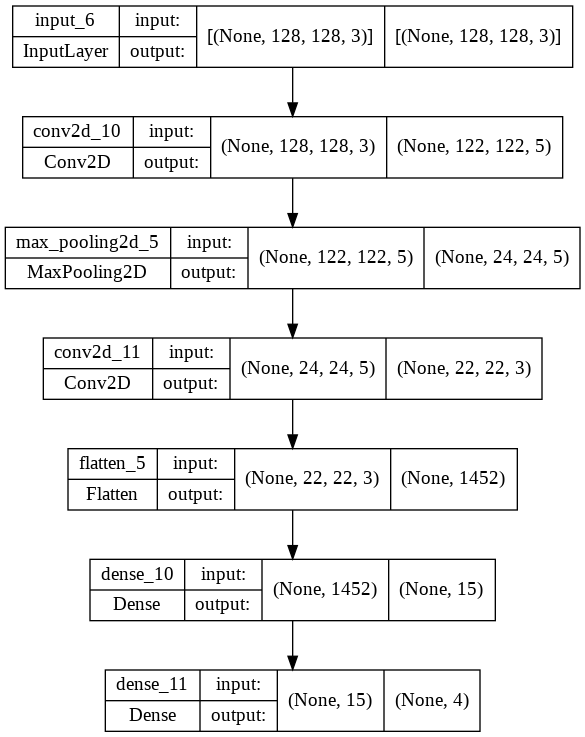

In [48]:
keras.utils.plot_model(model, show_shapes=True)

KerasGA # Create an instance of the pygad.kerasga.KerasGA class to build the initial population.

In [ ]:
keras_ga = kerasga.KerasGA(model=model,
                                 num_solutions=10)

Entrada de datos

In [ ]:
data_inputs = open_images(train_paths[:1000])
data_outputs = train_labels[:1000]



In [ ]:
data_outputs = tensorflow.keras.utils.to_categorical(data_outputs)

Parametros de PyGAD

In [ ]:
num_generations = 500 # NUmero de generaciones
num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.
initial_population = keras_ga.population_weights # Initial population of network weights.

In [ ]:
def mutation_func(offspring, ga_instance):

    for chromosome_idx in range(offspring.shape[0]):
        random_gene_idx = numpy.random.choice(range(offspring.shape[1]))

        offspring[chromosome_idx, random_gene_idx] += numpy.random.random()

    return offspring

In [ ]:
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        random_split_point = numpy.random.choice(range(offspring_size[1]))

        parent1[random_split_point:] = parent2[random_split_point:]

        offspring.append(parent1)

        idx += 1

    return numpy.array(offspring)

In [ ]:
def mutation_func(offspring, ga_instance):

    for chromosome_idx in range(offspring.shape[0]):
        random_gene_idx = numpy.random.choice(range(offspring.shape[1]))

        offspring[chromosome_idx, random_gene_idx] += numpy.random.random()

    return offspring

In [ ]:
def parent_selection_func(fitness, num_parents, ga_instance):

    fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
    fitness_sorted.reverse()

    parents = numpy.empty((num_parents, ga_instance.population.shape[1]))

    for parent_num in range(num_parents):
        parents[parent_num, :] = ga_instance.population[fitness_sorted[parent_num], :].copy()

    return parents, fitness_sorted[:num_parents]

*# Create an instance of the pygad.GA class

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       parent_selection_type=parent_selection_func)

Comienzo del algoritmo de evolucion genetica

In [ ]:
import numpy

In [ ]:
ga_instance.run()

Visualizacion del entrenamiento

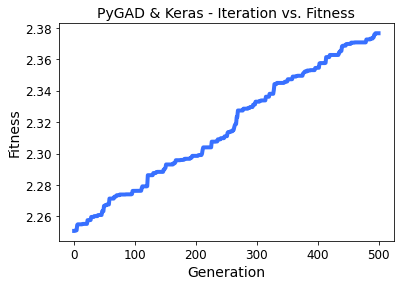

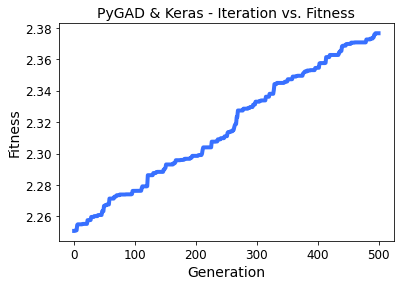

In [ ]:
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

Mejor solucion

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = 2.376464134076088
Index of the best solution : 0


Prediccion

In [ ]:
predictions = pygad.kerasga.predict(model=model,
                                    solution=solution,
                                    data=data_inputs)
print("Predictions : \n", predictions)

Predictions : 
 [[1.2581144e-01 8.6576623e-01 8.2939044e-03 1.2843948e-04]
 [1.7795980e-02 8.1140643e-01 3.7451416e-02 1.3334619e-01]
 [5.3423035e-01 4.6489298e-01 3.2214890e-04 5.5451045e-04]
 ...
 [6.3684696e-01 1.4481388e-01 4.1165542e-02 1.7717367e-01]
 [1.5254866e-02 3.3994041e-02 9.5047015e-01 2.8105045e-04]
 [1.7479920e-01 8.2513827e-01 2.2178850e-05 4.0413710e-05]]


*# Calculate the categorical crossentropy for the trained model.

In [ ]:
cce = tensorflow.keras.losses.CategoricalCrossentropy()
print("Categorical Crossentropy : ", cce(data_outputs, predictions).numpy())

Categorical Crossentropy :  0.42079222


*# Calculate the classification accuracy for the trained model.

In [ ]:
ca = tensorflow.keras.metrics.CategoricalAccuracy()
ca.update_state(data_outputs, predictions)
accuracy = ca.result().numpy()
print("Accuracy : ", accuracy)

Accuracy :  0.86
